In [77]:
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
import re

np.set_printoptions(threshold=np.inf)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
data = pd.read_csv('wisconsin_data.csv')
print(data.shape)
data.head()

(698, 11)


,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


We'll try to drop the columns where at least one element would be missing. 

In [79]:
df = data.dropna(axis='columns')

In [80]:
df.head()

,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


We find that this will cost us a loss of more than 500 samples and our dataset will not make any sense. So, we try to clean/pre-process our dataset in a way where instead of dropping every column that have missing values we drop the empty columns or the columns with a majority of missing values. 

The last column is empty so we drop that column


In [81]:
data.head()

,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [82]:
df = pd.read_csv('wisconsin_data.csv',header=None)
df = df[~df[6].isin(['?'])]

In [83]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [84]:
df = df.astype(float)
df.iloc[:,10].replace(2, 0,inplace=True)
df.iloc[:,10].replace(4, 1,inplace=True)

In [85]:
scaled_df=df
names = df.columns[0:10]
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(df.iloc[:,0:10]) 
scaled_df = pd.DataFrame(scaled_df, columns=names)

df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025.0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,1002945.0,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,1015425.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,1016277.0,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,1017023.0,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0


After cleaning the data, we try to build our neural network and based on the few references that we went through (that are displayed on the project Github page) we'll build a 2 layer neural network. The different parameters will be introduced as comments throughout the neural network code

We are going to be assuming that the number of input nodes is equivalent to the number of features in our dataset. After cleaning our dataset we are left with 32 features that we'd be using as input nodes in our input layer of the neural network. 

# Neural Network Implementation Steps

1- Initialization of the network: determine the structure of the network including the number of layers, the number of nodes in each layer, the learning rate and the random weights for each layer

2- Forward pass of the network: Feeding the input through the different layers in the network and applying the appropriate activation function

3- Backward propagation: We move backwards through our network in order to update our weights as we learn about the differences between the predicted values and the output of the network

4- Update network: We then update the network as per what we learned from the backward pass

5- Test and Evaluate: We finally test how well our model is working by feeding in out test dataset

### We will first start by defining the activation functions
We will define both the sigmoid and Rectified Linear Unit (ReLu) functions 

In [21]:
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)

To calculate the back propagation we would need to define the derivative of both the Sigmoid and ReLu functions

In [22]:

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

### Below if the neural network class that initializes the network and also defines the functions for both forward pass and backward pass

In [100]:
# X is our input layer where the number of rows is the number of features and the number of columns is the samples we have available to train the network. In this specific case we'll have 32 features and 
# Y is the desired output of our network
# l is the number of layers in our network 
# dimension is the number of neurons in each layer
# output is the output that the network produces and has the same dimensions as Y
# dict1 is a dictionary data type that contains the weight (W) and bias (b) parameters for each layer in the network
# dict2 is a dictionary that will hold some intermediate vlaues and calculations that we'll need during the backward pass 

class neural_network:
    def __init__(self, x, y):
        self.debug = 0;
        self.X=x
        self.Y=y
        self.output=np.zeros((1,self.Y.shape[1])) #The output would have the same dimensions as y but would be initialized to all zeroes 
        self.l=2  #we're going to have 2 layers in our network
        self.dimension = [9, 15, 1] 
        self.dict1 = {}
        self.dict2 = {}
        self.grad = {}
        self.loss = []  #for a specific number of iterations we will create a list to store loss values for the network
        self.learning_rate=0.003
        self.samples = self.Y.shape[1] #the number of samples in our dataset
        self.threshold=0.5
        
        
    def nInit(self):    
        np.random.seed(1)
        self.dict1['W1'] = np.random.randn(self.dimension[1], self.dimension[0]) / np.sqrt(self.dimension[0]) 
        self.dict1['b1'] = np.zeros((self.dimension[1], 1))        
        self.dict1['W2'] = np.random.randn(self.dimension[2], self.dimension[1]) / np.sqrt(self.dimension[1]) 
        self.dict1['b2'] = np.zeros((self.dimension[2], 1))                
        return 
    
#####################################################################################################################
    
    
    #After initializing the network we'd want to implement the forward pass in the network ie. feeding the input through the layers in our network and applying the weights and the activation functions
    
    
    def forward(self):


        Z1 = self.dict1['W1'].dot(self.X) + self.dict1['b1'] 
        A1 = Relu(Z1)
        self.dict2['Z1'],self.dict2['A1']=Z1,A1
        
        Z2 = self.dict1['W2'].dot(A1) + self.dict1['b2']  
        A2 = Sigmoid(Z2)
        self.dict2['Z2'],self.dict2['A2']=Z2,A2

        self.output=A2
        loss=self.nloss(A2)
        return self.output, loss
    


    def nloss(self, output):
        loss = (1./self.samples) * (-np.dot(self.Y,np.log(output).T) - np.dot(1-self.Y, np.log(1-output).T))    
        return loss
    
######################################################################################################################    
    
    def backward(self):
        dLoss_output = - (np.divide(self.Y, self.output ) - np.divide(1 - self.Y, 1 - self.output))    
        
        dLoss_Z2 = dLoss_output * dSigmoid(self.dict2['Z2'])    
        dLoss_A1 = np.dot(self.dict1["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.dict2['A1'].shape[1] * np.dot(dLoss_Z2,self.dict2['A1'].T)
        dLoss_b2 = 1./self.dict2['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.dict2['Z1'])        
        dLoss_A0 = np.dot(self.dict1["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))
    
    
        self.dict1["W1"] = self.dict1["W1"] - self.learning_rate * dLoss_W1
        self.dict1["b1"] = self.dict1["b1"] - self.learning_rate * dLoss_b1
        self.dict1["W2"] = self.dict1["W2"] - self.learning_rate * dLoss_W2
        self.dict1["b2"] = self.dict1["b2"] - self.learning_rate * dLoss_b2
    
        return
    

#######################################################################################################################
    
    
    def pred(self,x, y):  
        self.X=x
        self.Y=y
        result = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    
    
        for i in range(0, pred.shape[1]):
            if pred[0,i] > self.threshold: 
                result[0,i] = 1
            else: 
                result[0,i] = 0
    
        print("Acc: " + str(np.sum((result == y)/x.shape[1])))
        
        return result
    
######################################################################################################################    
    
    
    def train(self,X, Y, iter = 3000):
        np.random.seed(1)                         
    
        self.nInit()
    
        for i in range(0, iter):
            output, loss=self.forward()
            self.backward()
            
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)
        
        plt.plot(np.squeeze(self.loss))
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.title("Learning rate =" + str(self.learning_rate))
        plt.show()
       
        return
    

In [101]:
y=df.iloc[0:500,10:].values.transpose()

xval=scaled_df.iloc[501:683,1:10].values.transpose()
yval=df.iloc[501:683,10:].values.transpose()

print(df.shape, x.shape, y.shape, xval.shape, yval.shape)

(683, 11) (9, 500) (1, 500) (9, 182) (1, 182)


In [102]:
nn = neural_network(x,y)
nn.learning_rate=0.07
nn.dimension = [9, 15, 1]

Cost after iteration 0: 0.673967
Cost after iteration 500: 0.122093
Cost after iteration 1000: 0.108469
Cost after iteration 1500: 0.103673
Cost after iteration 2000: 0.100911
Cost after iteration 2500: 0.099047
Cost after iteration 3000: 0.097530
Cost after iteration 3500: 0.096368
Cost after iteration 4000: 0.095480
Cost after iteration 4500: 0.094744


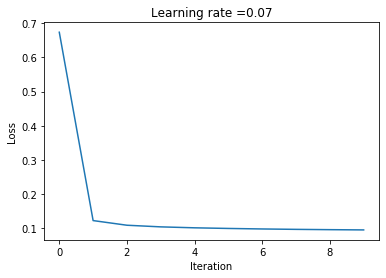

In [103]:
nn.train(x, y, iter = 5000)

### We finally come to the testing and evaluation phase where we define a confusion matrix and plot the actual values versus the predicted values for each of the test and training sets. 

This confusion matrix function comes from a reference that I mention on the repository's readme file and is used to plot the actual versus predicted values

In [105]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

Acc: 0.9720000000000003


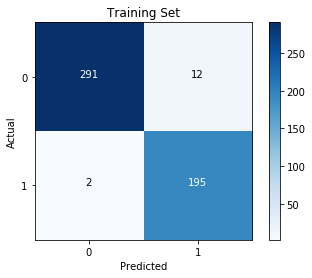

Acc: 0.989010989010989


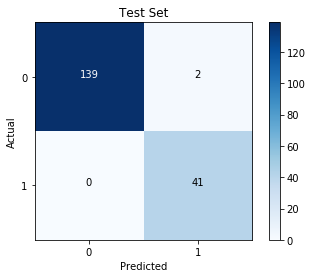

In [109]:
nn.threshold=0.2

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Test Set')

Acc: 0.9620000000000003


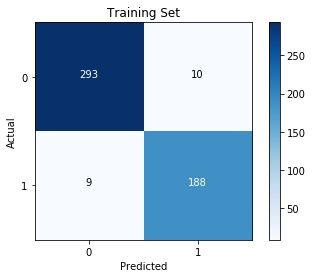

Acc: 1.0


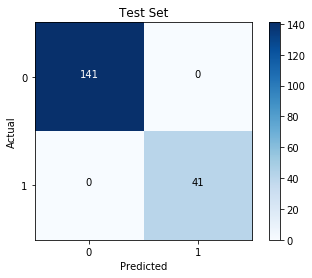

In [110]:
nn.threshold=0.5

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Test Set')

Acc: 0.9320000000000003


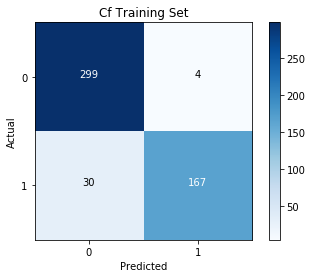

Acc: 0.989010989010989


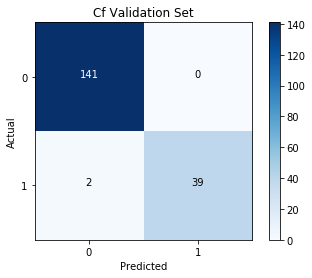

In [111]:
nn.threshold=0.9

nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

In [112]:
nn.X,nn.Y=xval, yval 
yvalh, loss = nn.forward()
print("\nActual",np.around(yval[:,0:50,], decimals=0).astype(np.int))       
print("\nPredicted",np.around(yvalh[:,0:50,], decimals=0).astype(np.int),"\n")


Actual [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

Predicted [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 

